# Real or Fake News Classification


In this capstone project, we attempt to build a fake news classifier using dataset taken from:- https://www.kaggle.com/code/benroshan/fake-news-classifier-lstm/data

There are two datasets - `True` and `Fake`. Each dataset has four columns containing `title`, `subject`, `text` and `date`.

Estimated reading time: **30** mins

***

# Import libraries and data

We will import the following data manipulation libaries for this project

In [1]:
import numpy as np # linear algebra # NumPy is a library for large, multi-dimensional arrays and matrices
import pandas as pd # Pandas is a library for data manipulation and analysis.
import matplotlib.pyplot as plt # Matplotlib is a library for plotting and pyplot gives us a MatLab like plotting framework
import seaborn as sns #Seaborn is data visualization library based on matplotlib

from wordcloud import WordCloud # WordCloud is a library for visualising text data where its size indicates frequency

import warnings # to ignore deprecation warnings
warnings.filterwarnings("ignore")


and import the datasets `True` and `Fake`

In [2]:
#import csv files
real = pd.read_csv("True.csv")
fake = pd.read_csv("Fake.csv")

We create a new column called `news_class` for both datasets, giving a numerical value of `1` for the `real` dataset and `0` for the `fake` dataset.  Thereafter, we concatenate both datasets into a DataFrame.

In [3]:
# create a column "news_class" with value 1 for real & 0 for fake
real["news_class"], fake["news_class"] = 1, 0

# Concatenate both real & fake datasets into one Dataframe
df = pd.concat([real, fake], axis=0)
df = df.sample(frac=1.0, random_state=0)
df.index = [i for i in range(df.shape[0])]

# Exploratory Data Analysis (EDA)
Let's examine what the DataFrame looks like by printing it

In [4]:
df

,title,text,subject,date,news_class
0,How John Oliver And A Cat Created An Internat...,Since John Oliver left the Daily Show to take ...,News,"May 24, 2016",0
1,U.N. Report: Police Killings Of Black Men In ...,The epidemic of black men being killed at the ...,News,"September 23, 2016",0
2,Boeing CEO says he assured Trump about Air For...,"PALM BEACH, Fla. (Reuters) - Boeing Co Chief E...",politicsNews,"December 21, 2016",1
3,Pelosi says she trusts Trump's sincerity on pr...,WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,"September 14, 2017",1
4,Putin Declares Syria A “No Fly Zone”…While Oba...,Does anyone remember Vladimir Putin pushing Ge...,Government News,"Oct 2, 2015",0
...,...,...,...,...,...
44861,Donald Trump Even Stole The Cake Design From ...,"At this point, it s fair to ask, What is Dona...",News,"January 21, 2017",0
44862,Trump urges Republicans to start tax reform im...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"September 8, 2017",1
44863,FOX News Anchor Shepard Smith Finally ‘Comes O...,"21st Century Wire says For many viewers, this ...",US_News,"October 18, 2016",0
44864,DEPLORABLES UNITE! ONE MORE DAY: “We will no l...,Les Deplorables Unite #ElectionNight #MAGA3X p...,politics,"Sep 22, 2016",0


<br>
Using `.info()` and `.isnull().sum()`, we ascertained that there were no null values

In [5]:
# to check for null
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44866 entries, 0 to 44865
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       44866 non-null  object
 1   text        44866 non-null  object
 2   subject     44866 non-null  object
 3   date        44866 non-null  object
 4   news_class  44866 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [6]:
# to quantify any null values
df.isnull().sum()

title         0
text          0
subject       0
date          0
news_class    0
dtype: int64

<br>
There were 209 duplicate values which were then dropped

In [7]:
# to detect any duplicate values
df.duplicated().sum()

209

In [8]:
# dropped the duplicate values
df.drop_duplicates

<bound method DataFrame.drop_duplicates of                                                    title  \
0       How John Oliver And A Cat Created An Internat...   
1       U.N. Report: Police Killings Of Black Men In ...   
2      Boeing CEO says he assured Trump about Air For...   
3      Pelosi says she trusts Trump's sincerity on pr...   
4      Putin Declares Syria A “No Fly Zone”…While Oba...   
...                                                  ...   
44861   Donald Trump Even Stole The Cake Design From ...   
44862  Trump urges Republicans to start tax reform im...   
44863  FOX News Anchor Shepard Smith Finally ‘Comes O...   
44864  DEPLORABLES UNITE! ONE MORE DAY: “We will no l...   
44865  'Is a Tweet policy?' State Department official...   

                                                    text          subject  \
0      Since John Oliver left the Daily Show to take ...             News   
1      The epidemic of black men being killed at the ...             News   
2    

In [9]:
# count of subjects
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9049
politics            6833
left-news           4454
Government News     1568
US_News              775
Middle-east          770
Name: subject, dtype: int64

In [10]:
# count of class
df.groupby("news_class").count()

,title,text,subject,date
news_class,,,,
0,23449,23449,23449,23449
1,21417,21417,21417,21417


In [11]:
# Starting and end date of the dataset
df['date'] = pd.to_datetime(df['date'])
date_range = str(df['date'].dt.date.min()) + ' to ' + str(df['date'].dt.date.max())
date_range

'2015-03-31 to 2018-02-19'

# Data Visualisation

Based on the visualisation of the data, we can see that the label `news_class` is relatively balanced but the column `subject` is not.  Likewise, an inspection of  `WordCloud` for the column `text` shows a balanced distribution of the most frequently used words in both the `real` and `fake` dataset. As a result, we will drop `subject`, `title` and `date`, focusing our analysis solely on `text`.

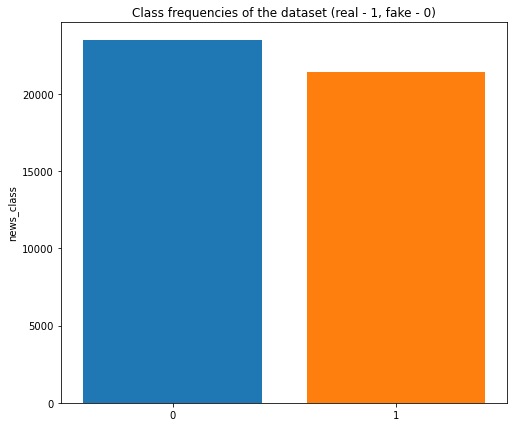

In [12]:
# A balanced Real vs. Fake news class
plt.figure(figsize = [8, 7], clear = True, facecolor = 'white')

sns.barplot(x = df["news_class"].value_counts().index,
            y = df["news_class"].value_counts(),
            saturation = 1).set(title = "Class frequencies of the dataset (real - 1, fake - 0)");

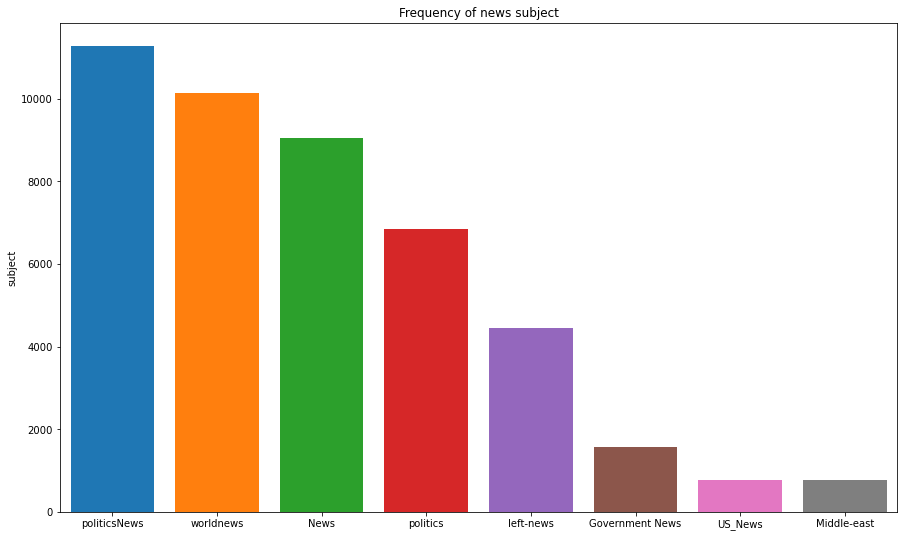

In [13]:
# A relatively imbalanced spread of news subjects
plt.figure(figsize = [15, 9], clear = True, facecolor = 'white')
sns.barplot(x = df["subject"].value_counts().index,
            y = df["subject"].value_counts(),
            saturation = 1).set(title = "Frequency of news subject");

In [14]:
# News subject by Real or Fake class
pd.crosstab(df["news_class"], df["subject"])

subject,Government News,Middle-east,News,US_News,left-news,politics,politicsNews,worldnews
news_class,,,,,,,,
0,1568,770,9049,775,4454,6833,0,0
1,0,0,0,0,0,0,11272,10145


<function matplotlib.pyplot.show(close=None, block=None)>

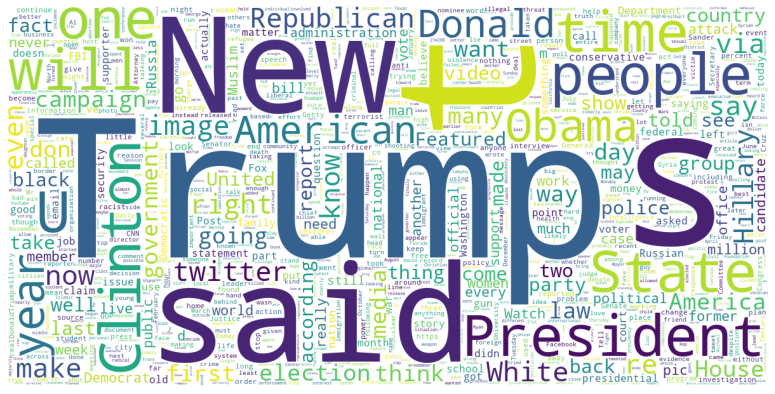

In [15]:
#Wordcloud for fake news
text = " ".join(i for i in fake.text)

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "red", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

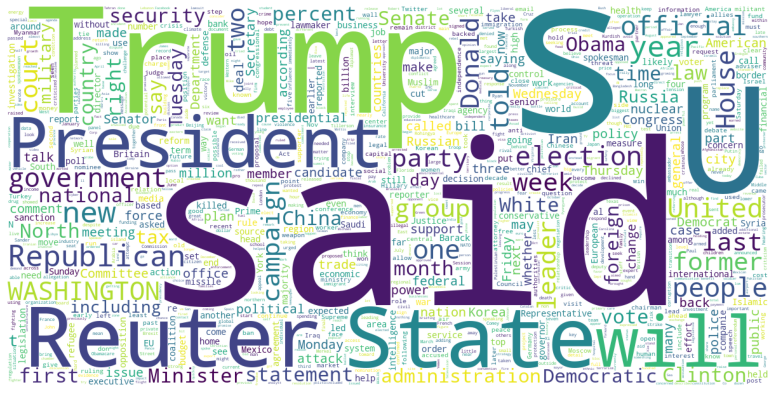

In [16]:
#Wordcloud for real news
text = " ".join(i for i in real.text)

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "red", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

In [17]:
# As a result of EDA above, we drop columns title, subject and date
df.drop(['title', 'subject', "date"], axis=1, inplace=True)

# Split the dataset into training and testing sets
Now that we have a DataFrame containing news articles in the `text` column and `real` or `fake` labels in `news_class`, we split the dataset into 80% for training and 20% for testing

In [18]:
# Splitting our data into training and testing datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["text"], df["news_class"], test_size = 0.2, shuffle = True,
                                                    stratify = df["news_class"],
                                                    random_state = 42)

# Preprocessing

Before we can fit a model to the data, we need to preprocess the data by using a vectorizer to transform the collection of `text` articles into matrix of features.  For the vectorizer, we use scikit-learn's module Term Frequency Inverse Document Frequency Vectorizer `TfidfVectorizer`. A `TfidfVectorizer` gives more weight to a word that occurs frequently within **an** article but less weight to a word that occurs frequently across **all** articles. It turns the column of `text` articles into a matrix of TF-IDF features

In [19]:
#importing tf-idf vectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Initialize a TfidfVectorizer with a maximum stop word frequency of 0.7
tfidf_vect =TfidfVectorizer(stop_words='english', max_df=0.7)

# Fit and transform train set, transform test set
tfidf_Xtrain = tfidf_vect.fit_transform(X_train) 
tfidf_Xtest = tfidf_vect.transform(X_test)

# Model Building

Now we will build models on the matrix of TF-IDF features from the training dataset.  Specifically, we will use supervised learning algorithms of `LogisticRegression`, `naive_bayes`, `LinearSVC`, `DecisionTreeClassifier`, `KNeighborsClassifier`.  Using the models' respective `classification_report` and `confusion_matrix`, we will then shortlist models with high accuracy, precision and recall. Subsequently, we will put the shortlisted models to the test using the test dataset.  Also, we will use the unsupervised learning algorithm of `KMeans` clustering to see if we can classify the news without the use of labels.

In [20]:
# importing libraries for the various machine learning models to be used for classification
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# importing metrics for checking the models' accuracy
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Supervised Learning
### 1. Logistic Regression

We instantiate `LogisticRegression`, fit the model, predict the target, generate `confusion_matrix`, print its accuracy and `classification_report`

In [21]:
# LogisticRegression
logit = LogisticRegression()
logit.fit(tfidf_Xtrain, y_train)

LogisticRegression()

In [22]:
y_pred = logit.predict(tfidf_Xtest)
cmlogit = confusion_matrix(y_test, y_pred)
cmlogit

array([[4617,   73],
       [  55, 4229]], dtype=int64)

In [23]:
print('The accuracy of the Logistic Regression is:',accuracy_score(y_test,y_pred))

The accuracy of the Logistic Regression is: 0.9857365723200356


In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4690
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8974
   macro avg       0.99      0.99      0.99      8974
weighted avg       0.99      0.99      0.99      8974



### 2. Naive Bayes
We use `GridSearchCV` to search for the hyperparameter alpha that gives the highest F1-score for `MultinomialNB`

In [25]:
# Hyperparameter tuning using K-fold cross validation via Grid Search method
from sklearn.model_selection import GridSearchCV

clf = MultinomialNB()
param_grid = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001]} # we arbitrarily assign these numbers to alpha for gridsearch

gs_clf = GridSearchCV(clf,
                      param_grid,
                      cv=5,
                      scoring='f1_macro',
                      n_jobs=-1) 

gs_clf.fit(tfidf_Xtrain, y_train)
print("'{}' gives the best F1-score at: {:.2%}".format(gs_clf.best_params_, gs_clf.best_score_))

'{'alpha': 0.001}' gives the best F1-score at: 94.37%


We instantiate `MultinomialNB` with an alpha of 0.001 and fit the model on the training data.  The `confusion_matrix`, accuracy and `classification_report` are generated.

In [26]:
# using alpha = 0.001 as it gives the best F1-score
nb = MultinomialNB(alpha = 0.001)
nb.fit(tfidf_Xtrain, y_train)

MultinomialNB(alpha=0.001)

In [27]:
#confusion matrix
y_prednb = nb.predict(tfidf_Xtest)
cmnb = confusion_matrix(y_test, y_prednb)
cmnb

array([[4499,  191],
       [ 272, 4012]], dtype=int64)

In [28]:
print('The accuracy of the Naive Bayes is:', accuracy_score(y_test,y_prednb))

The accuracy of the Naive Bayes is: 0.948406507688879


In [29]:
print(classification_report(y_test, y_prednb))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4690
           1       0.95      0.94      0.95      4284

    accuracy                           0.95      8974
   macro avg       0.95      0.95      0.95      8974
weighted avg       0.95      0.95      0.95      8974



### 3. Support Vector Machine

We instantiate `LinearSVC`, fit the model, predict the target, generate `confusion_matrix`, print its accuracy and `classification_report`

In [30]:
# SVM
svc = LinearSVC()
svc.fit(tfidf_Xtrain, y_train)

LinearSVC()

In [31]:
#confusion matrix
y_predsvc = svc.predict(tfidf_Xtest)
cmsvc = confusion_matrix(y_test, y_predsvc)
cmsvc

array([[4655,   35],
       [  14, 4270]], dtype=int64)

In [32]:
print('The accuracy of the SVM is:', accuracy_score(y_test,y_predsvc))

The accuracy of the SVM is: 0.9945397815912637


In [33]:
print(classification_report(y_test, y_predsvc))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4690
           1       0.99      1.00      0.99      4284

    accuracy                           0.99      8974
   macro avg       0.99      0.99      0.99      8974
weighted avg       0.99      0.99      0.99      8974



### 4. Decision Tree
We instantiate `DecisionTreeClassifier`, fit the model, predict the target, generate `confusion_matrix`, print its accuracy and `classification_report`

In [34]:
# Decision Tree
dt = DecisionTreeClassifier(criterion='entropy', random_state = 42)
dt.fit(tfidf_Xtrain, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [35]:
# Confusion matrix
y_preddt = dt.predict(tfidf_Xtest)
cmdt = confusion_matrix(y_test, y_preddt)
cmdt

array([[4668,   22],
       [  23, 4261]], dtype=int64)

In [36]:
print('The accuracy of the Decsion Trees is:', accuracy_score(y_test,y_preddt))

The accuracy of the Decsion Trees is: 0.9949855137062625


In [37]:
print(classification_report(y_test, y_preddt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4690
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8974
   macro avg       0.99      0.99      0.99      8974
weighted avg       0.99      0.99      0.99      8974



[Text(0.6078431372549019, 0.9285714285714286, 'X[83795] <= 0.005\nentropy = 0.999\nsamples = 35892\nvalue = [18759, 17133]'),
 Text(0.37254901960784315, 0.7857142857142857, 'X[110105] <= 0.543\nentropy = 0.019\nsamples = 18561\nvalue = [18528, 33]'),
 Text(0.3333333333333333, 0.6428571428571429, 'X[70573] <= 0.02\nentropy = 0.016\nsamples = 18556\nvalue = [18528, 28]'),
 Text(0.19607843137254902, 0.5, 'X[48811] <= 0.057\nentropy = 0.012\nsamples = 18418\nvalue = [18399, 19]'),
 Text(0.1568627450980392, 0.35714285714285715, 'X[74168] <= 0.046\nentropy = 0.01\nsamples = 18415\nvalue = [18399, 16]'),
 Text(0.0784313725490196, 0.21428571428571427, 'X[98925] <= 0.016\nentropy = 0.008\nsamples = 18376\nvalue = [18364, 12]'),
 Text(0.0392156862745098, 0.07142857142857142, '\n  (...)  \n'),
 Text(0.11764705882352941, 0.07142857142857142, '\n  (...)  \n'),
 Text(0.23529411764705882, 0.21428571428571427, 'X[18302] <= 0.011\nentropy = 0.477\nsamples = 39\nvalue = [35, 4]'),
 Text(0.19607843137254

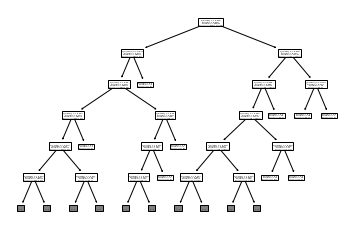

In [38]:
tree.plot_tree(dt, max_depth = 5)

### 5. K Nearest Neighbours

We instantiate `KNeighborsClassifier`, fit the model, predict the target, generate `confusion_matrix`, print its accuracy and `classification_report`

In [39]:
# KNN
knn = KNeighborsClassifier()
knn.fit(tfidf_Xtrain, y_train)

KNeighborsClassifier()

In [40]:
# Confusion matrix
y_predknn = knn.predict(tfidf_Xtest)
cmknn = confusion_matrix(y_test, y_predknn)
cmknn

array([[4638,   52],
       [3118, 1166]], dtype=int64)

In [41]:
print('The accuracy of KNN is:', accuracy_score(y_test,y_predknn))

The accuracy of KNN is: 0.6467572988633831


In [42]:
print(classification_report(y_test, y_predknn))

              precision    recall  f1-score   support

           0       0.60      0.99      0.75      4690
           1       0.96      0.27      0.42      4284

    accuracy                           0.65      8974
   macro avg       0.78      0.63      0.58      8974
weighted avg       0.77      0.65      0.59      8974



### Shortlisting the models

We get an overview of models' precision and recall by plotting and comparing their confusion matrices

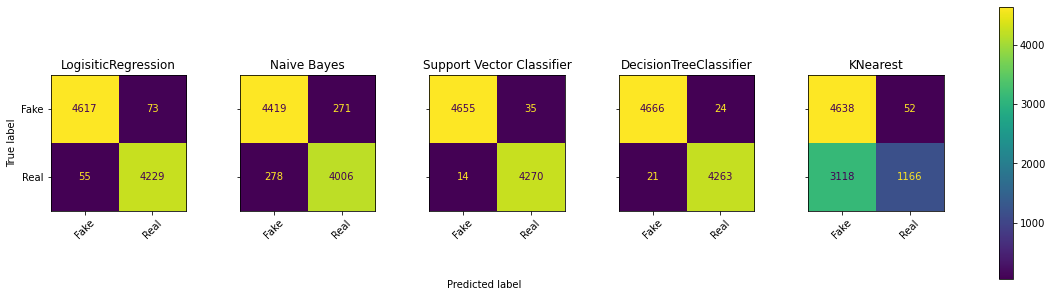

In [43]:
#plotting the confusion matrices of the models side-by-side
class_name = pd.array(["Fake", "Real"])

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),  
    "Support Vector Classifier": LinearSVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "KNearest": KNeighborsClassifier(),
}

    
f, axes = plt.subplots(1, 5, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(tfidf_Xtrain, y_train).predict(tfidf_Xtest)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=class_name)
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

From the `confusion_matrix` of the 5 models, we see that all models except `KNeighborsClassifier` have relatively low false positives and false negatives. This result is further reinforced by the `f1-score` from the `classification_report` where `KNeighborsClassifier` returned a relatively low `f1-score` of 0.58 compared to at least 0.95 for the other models.  In addition, the accuracy of `KNeighborsClassifier` was a low 0.64 compared to 0.95 for the other models.  On this basis, we drop `KNeighborsClassifier` and shortlist the remaining 4 models for our subsequent classification of test data.

## Unsupervised Learning
### K Means

We use the unsupervised learning algorithm of `KMeans` to see if it can return clusters that have higher accuracy

In [44]:
# KMeans
from sklearn.cluster import KMeans

# Within Cluster Sum of Squares distance (WCSS)
wcss = []

# Fitting KMeans over a range of 1 to 16 clusters
for i in range(1,16):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(tfidf_Xtrain)
    wcss.append(kmeans.inertia_) 

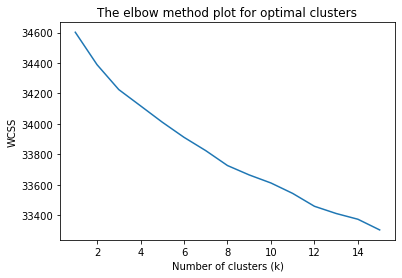

In [45]:
# Plotting the results on a line chart so as to allow us to identify the elbow
plt.plot(range(1,16), wcss)
plt.title('The elbow method plot for optimal clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

As we can see from the plot, the elbow does not seem to occur at any level of k.  But for our purpose of classifying news as `real` or `fake`, involving only 2 clusters, the elbow should ideally be at k=2.  This suggests that `KMeans` may not return `real`/`fake` clusters that are more accurate than the labels. We shall proceed with setting `n_clusters` = 2 for `KMeans` to validate this observation.

In [46]:
# Given that there are only 2 classes - real or fake, we set clusters = 2
kmeans = KMeans(n_clusters= 2, random_state = 42)  

y_kmeans = kmeans.fit_predict(tfidf_vect.transform(df.text))
df['Cluster'] = y_kmeans
df.head()

,text,news_class,Cluster
0,Since John Oliver left the Daily Show to take ...,0,0
1,The epidemic of black men being killed at the ...,0,0
2,"PALM BEACH, Fla. (Reuters) - Boeing Co Chief E...",1,1
3,WASHINGTON (Reuters) - U.S. House of Represent...,1,0
4,Does anyone remember Vladimir Putin pushing Ge...,0,0


Visually, we can see from the table above that a 2 cluster `KMeans` is not returning a similar result to the `news_class` labels.  We then proceed to calculate the % of correctly classified news

In [47]:
# Calculate the % of correctly classified news

correct = 0
incorrect = 0
for index, row in df.iterrows():
    if row['news_class'] == row['Cluster']:
        correct += 1
    else:
        incorrect += 1
        
print("Correctly classified news: " + str((correct*100)/(correct+incorrect)) + "%")

Correctly classified news: 44.757722997369946%


From the result above, the percentage of correctly classified news is a low 45%.  As such, we will not proceed further with `KMeans` algorithm.

# Creating a function to return the classification results of the algorithms

In [48]:
# A function to classify and return the probabilities of real or fake news using Logistic Regression, Naive Bayes, 
# Decision Tree & SVM 
def classify(feature):
    my_feature = pd.Series(feature)
    tfidf_my_feature = tfidf_vect.transform(my_feature)
    logit_pred = logit.predict(tfidf_my_feature)
    svm_pred = svc.predict(tfidf_my_feature)
    dt_pred = dt.predict(tfidf_my_feature)
    nb_pred = nb.predict(tfidf_my_feature)
    logit_pred_prob = logit.predict_proba(tfidf_my_feature)
    dt_pred_prob = dt.predict_proba(tfidf_my_feature)
    nb_pred_prob = nb.predict_proba(tfidf_my_feature)
    print("Logistic Regression: ", logit_pred, " Probability: ", logit_pred_prob[:,1])
    print("Naive Bayes: ", nb_pred, " Probability: ", nb_pred_prob[:,1])
    print("Decision Tree: ", dt_pred, " Probability: ", dt_pred_prob[:,1])
    print("SVM: ", svm_pred)
   

## Classify news from test dataset

We print out 10 randomly ordered news articles from the test data set by returning `X_test` and `y_test`

In [49]:
X_test, y_test

(30562    MANILA (Reuters) - Philippine President Rodrig...
 24660    CAIRO (Reuters) - An Egyptian lawmaker is intr...
 34973    WASHINGTON (Reuters) - U.S. Treasury Secretary...
 29273    Like dominoes, the Hijra keeps marching across...
 7368     We are all aware by now of Donald Trump s raci...
                                ...                        
 4063     Sometimes, Donald Trump says something so stup...
 14387    BUENOS AIRES (Reuters) - Argentina s top prose...
 4202     WASHINGTON (Reuters) - AFL-CIO President Richa...
 3334     CNN Reports   Three members of the legal team ...
 22021    WASHINGTON (Reuters) - President Barack Obama ...
 Name: text, Length: 8974, dtype: object,
 30562    1
 24660    1
 34973    1
 29273    0
 7368     0
         ..
 4063     0
 14387    1
 4202     1
 3334     0
 22021    1
 Name: news_class, Length: 8974, dtype: int64)

We select 2 `real` news articles from indices `30562` and `24660`

In [50]:
# real news from index 30562 of test dataset
my_feature = X_test[30562]
my_feature

'MANILA (Reuters) - Philippine President Rodrigo Duterte urged the United States on Tuesday to help control drugs smuggling, blaming Taiwan and Hong Kong-based criminal gangs for using his country as a shipping hub. In a speech, he also said illegal drugs had funded the seizure by Islamist militants of large parts of the southern city of Marawi in May. More than 800 people have died in the conflict, which Duterte said was triggered by an attempt to arrest a drug personality, who he did not identify.   The Philippines is a transhipment of shabu to America,  Duterte told members of the Philippine Constitution Association, referring to the local term for methamphetamine.  It behoves upon America to work closely with the Republic of the Philippines, especially on this serious matter.  Duterte, who was elected 16 months ago on promises to fight corruption, crime and drugs, said the so-called 14-K triads in Hong Kong and the Taiwan-based Bamboo triads were using the country as a transhipment

In [51]:
# real or fake News classifier
classify(my_feature)

Logistic Regression:  [1]  Probability:  [0.96938938]
Naive Bayes:  [1]  Probability:  [0.99974338]
Decision Tree:  [1]  Probability:  [1.]
SVM:  [1]


We see that all four models correctly classified the news from index `30562` as `real`

In [52]:
# real news from index 24660 of test dataset
my_feature = X_test[24660]
my_feature

'CAIRO (Reuters) - An Egyptian lawmaker is introducing a draft bill that would imprison those engaging in or promoting same-sex relations, a copy of the draft seen by Reuters on Thursday showed. Amnesty International said the bill is  another nail in the coffin for sexual rights in Egypt  and should be scrapped. It would introduce sentences of to up to 10 years in prison for people engaging in or promoting same-sex relations. The law is part of a wider crackdown against homosexuality that started in September when a group of people were seen raising a rainbow flag at a concert, a rare public show of support for lesbian, gay, bisexual and transgender rights in the conservative Muslim country.  If passed, this law would further entrench stigma and abuse against people based on their perceived sexual orientation,  said Najia Bounaim, North Africa Campaigns Director at Amnesty International.  The Egyptian authorities must urgently scrap this draft law and put an end to this alarming wave o

In [53]:
# real or fake news classifier
classify(my_feature)

Logistic Regression:  [1]  Probability:  [0.95359607]
Naive Bayes:  [1]  Probability:  [0.99884607]
Decision Tree:  [1]  Probability:  [1.]
SVM:  [1]


Similarly, we see that all four models correctly classified the news from index `24660` as `Real`.
<br>
<br>
<br>
Now we select two `fake` news articles from indices `29273` and `7368`.

In [54]:
# fake news from index 29273 of test dataset
my_feature = X_test[29273]
my_feature

'Like dominoes, the Hijra keeps marching across Europe, destroying the distinct cultures of one country after another. Sweden and the UK are in big trouble France is next and thanks to bleeding heart liberal Democrats in America, the U.S. isn t be far behind At least 85 Islamic sharia courts are operating in Britain, a study claimed yesterday.The astonishing figure is 17 times higher than previously accepted.The tribunals, working mainly from mosques, settle financial and family disputes according to religious principles. They lay down judgments which can be given full legal status if approved in national law courts.However, they operate behind doors that are closed to independent observers and their decisions are likely to be unfair to women and backed by intimidation, a report by independent think-tank Civitas said.Commentators on the influence of sharia law often count only the five courts in London, Manchester, Bradford, Birmingham and Nuneaton that are run by the Muslim Arbitratio

In [55]:
# real or fake News classifier
classify(my_feature)

Logistic Regression:  [0]  Probability:  [0.09746328]
Naive Bayes:  [0]  Probability:  [0.01187902]
Decision Tree:  [0]  Probability:  [0.]
SVM:  [0]


We see that all four models correctly classified the news from index `29273` as `fake`

In [56]:
# fake news from index 7368 of test dataset
my_feature = X_test[7368]
my_feature

'We are all aware by now of Donald Trump s racist rhetoric. One young but very intelligent and articulate student understands how the media can at times sensationalize everything, so he decided to see for himself by attending a Trump rally. His findings were not surprising: Trump s followers are very racist. James Patterson, whose high school assignment was for him to volunteer at Trump s campaign as part of a student-based civics activity, perfectly analyzes the Trump phenomenon and he exemplifies what racists are afraid of: The baseline of his campaign is to make America white again. It speaks to fundamentalist Christian, white middle class Americans who feel like their power has been taken. Even though that s a false accusation, they feel like because minorities are making strides that they re losing power. [youtube https://www.youtube.com/watch?v=Bh8VGKqqunA]Patterson was also stunned to see just how many people actually support Donald Trump. He said: That s the scary part about th

In [57]:
# real or fake News classifier
classify(my_feature)

Logistic Regression:  [0]  Probability:  [0.00556596]
Naive Bayes:  [0]  Probability:  [3.52823053e-05]
Decision Tree:  [0]  Probability:  [0.]
SVM:  [0]


Likewise, we see that all four models correctly classified the news from index `7368` as `fake`.<br>
<br>
All 4 models correctly classified the 4 randomly chosen news articles as `real` or `fake` from the test dataset.  Next, we shall see how these 4 models perform by classifying news articles from main stream media and social media on August 2022.

## Classify news from main stream media and social media on August 2022
### Real News #1
We now extract `real` news as reported in the main stream media on August 2022 and see how the classification models perform

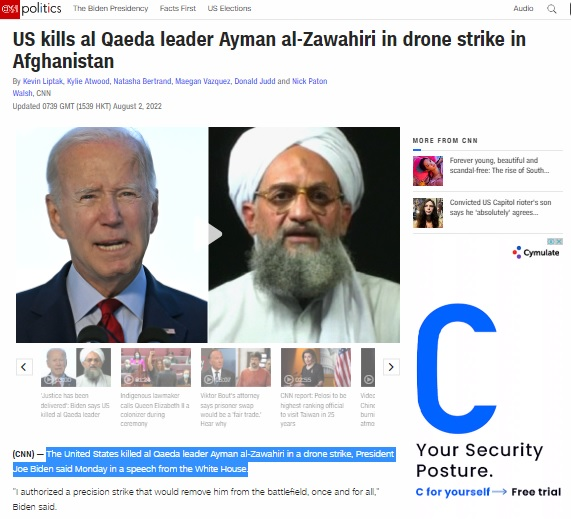

In [58]:
# News from main stream media on August 2022

my_feature = "The United States killed al Qaeda leader Ayman al-Zawahiri in a drone strike, President Joe Biden said Monday in a speech from the White House."
my_feature

'The United States killed al Qaeda leader Ayman al-Zawahiri in a drone strike, President Joe Biden said Monday in a speech from the White House.'

In [59]:
# real or fake news classifier
classify(my_feature)

Logistic Regression:  [1]  Probability:  [0.63385179]
Naive Bayes:  [1]  Probability:  [0.98578002]
Decision Tree:  [0]  Probability:  [0.]
SVM:  [0]


Interestingly, only `LogisticRegression` and `naive_bayes` correctly classified this news as `real`, with `DecisionTree` and `SVM` classifying as `fake`.
<br>
<br>
<br>
<br>
### Real News #2

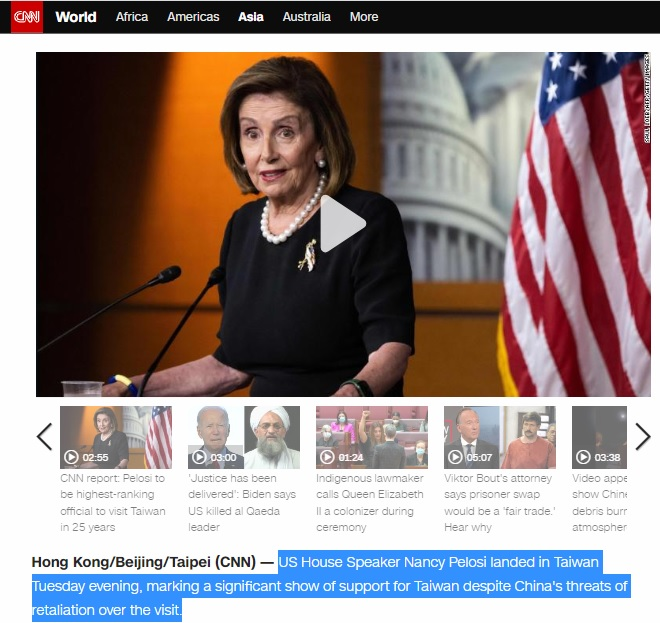

In [60]:
# News from main stream media on August 2022

my_feature = "US House Speaker Nancy Pelosi landed in Taiwan Tuesday evening, marking a significant show of support for Taiwan despite China's threats of retaliation over the visit."
my_feature

"US House Speaker Nancy Pelosi landed in Taiwan Tuesday evening, marking a significant show of support for Taiwan despite China's threats of retaliation over the visit."

In [61]:
# real or fake news classifier
classify(my_feature)

Logistic Regression:  [1]  Probability:  [0.60780892]
Naive Bayes:  [1]  Probability:  [0.94367411]
Decision Tree:  [0]  Probability:  [0.00200803]
SVM:  [0]


Similarly, only `LogisticRegression` and `naive_bayes` correctly classified this news about Pelosi landing in Taiwan as `real`.  Both `DecisionTree` and `SVM` classified as `fake`.
<br>
<br>
<br>
<br>
### Fake News #1

We now extract `fake` news as reported in social media on August 2022, fact checked by AP News.

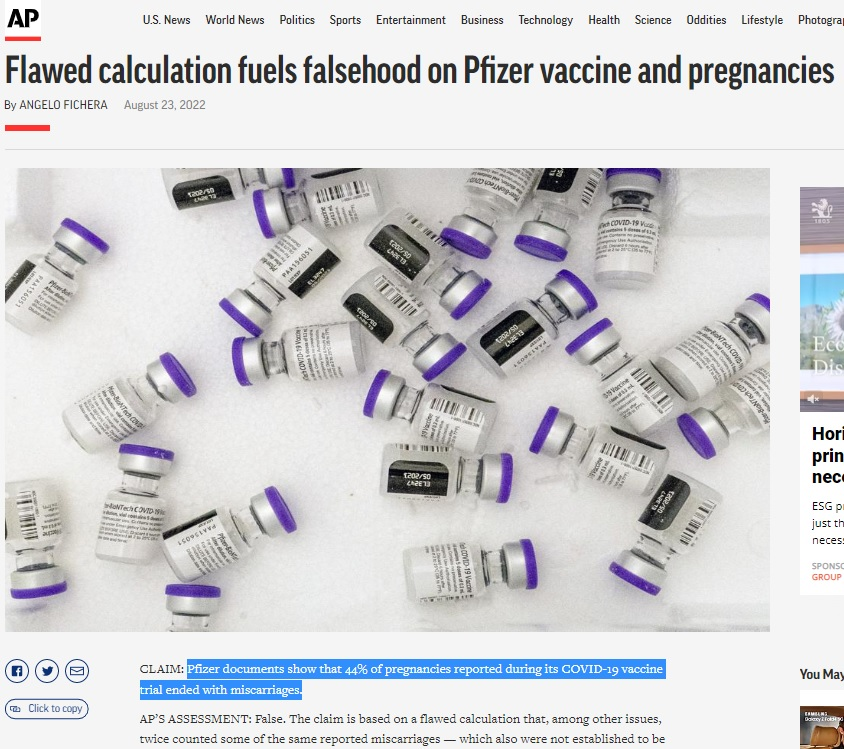

In [62]:
# fake news circulating on social media on August 2022
my_feature = "Pfizer documents show that 44% of pregnancies reported during its COVID-19 vaccine trial ended with miscarriages."
my_feature

'Pfizer documents show that 44% of pregnancies reported during its COVID-19 vaccine trial ended with miscarriages.'

In [63]:
# real or fake news classifier
classify(my_feature)

Logistic Regression:  [0]  Probability:  [0.23369821]
Naive Bayes:  [0]  Probability:  [0.4538203]
Decision Tree:  [0]  Probability:  [0.00200803]
SVM:  [0]


All four models correctly classified this news as `fake`
<br>
<br>
<br>
<br>
### Fake News #2

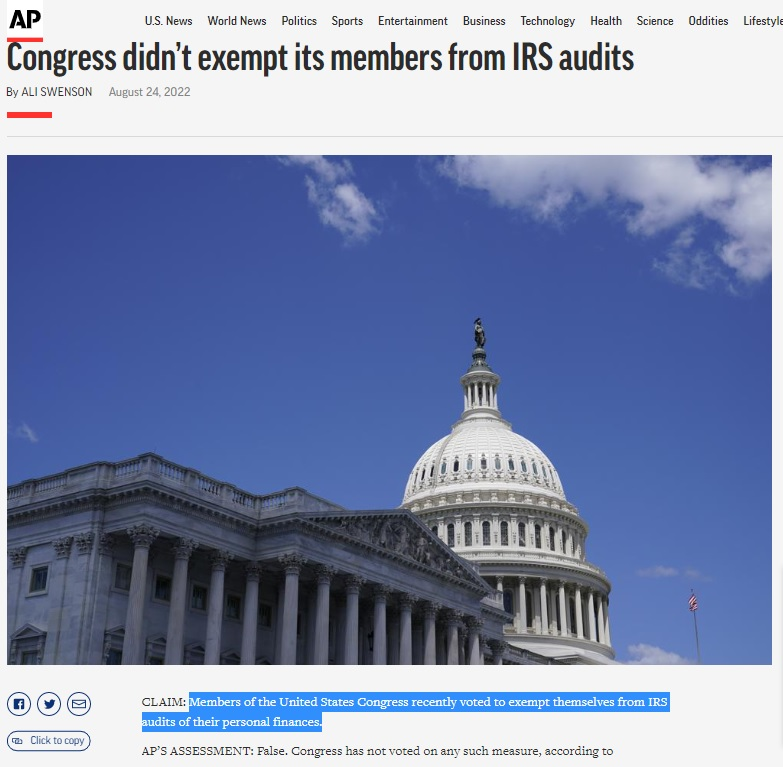

In [64]:
# fake news circulating on social media during August 2022
my_feature = "Members of the United States Congress recently voted to exempt themselves from IRS audits of their personal finances."
my_feature

'Members of the United States Congress recently voted to exempt themselves from IRS audits of their personal finances.'

In [65]:
# real or fake news classifier
classify(my_feature)

Logistic Regression:  [0]  Probability:  [0.10727959]
Naive Bayes:  [0]  Probability:  [0.48905969]
Decision Tree:  [0]  Probability:  [0.00200803]
SVM:  [0]


Similar to `fake` news #1, all four models correctly classified this news as `fake`

# Observations & Conclusion

 - The supervised learning model of `KNeighborsClassifier` and unsupervised learning model of `KMeans` were not so appropriate as `fake` news classifiers because of low recall and low accuracy respectively.
<br>
 - The remaining four supervised models:- `LogisticRegression`, `naive_bayes`, `DecisionTreeClassifier` and `LinearSVC` correctly classified 4 randomly chosen news articles from the test dataset.
 <br>
 
 - All four models also correctly classified 2 `fake` news articles from social media on August 2022.  However, only `LogisticRegression` and `naive_bayes` correctly classified `real` news from main stream media on August 2022, with `DecisionTreeClassifier` and `LinearSVC` returning a false negative result.
 <br>
 - Returning false negative does not mean that `DecisionTreeClassifier` and `LinearSVC` are inferior to `LogisticRegression` and `naive_bayes` in classifying `real` news. It could be that these models go beyond X/y or simple probabilistic prediction that may not work so well with the `tfidfvectorizer`preprocessor.
 <br>
 - It warrants further research to see if `DecisionTreeClassifier` and `LinearSVC` do not return false negative on the 2 `real` news articles when used  with other lemmatizer or tokenizer or sentiment analysis.